In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import re
import numpy as np

In [109]:
# Connessione al database SQL
conn = sqlite3.connect('database.db')
query_Y = "SELECT * FROM Y"  
Y = pd.read_sql_query(query_Y, conn)
query_Q = "SELECT * FROM Q"
Q = pd.read_sql_query(query_Q, conn)
query_X = "SELECT * FROM X"
X = pd.read_sql_query(query_X, conn)
# Chiusura della connessione
conn.close()

In [110]:
# Funzione per modificare la colonna 'th_names'
def modify_th_names(th_name):
    # Aggiungere uno 0 tra 'h' e una cifra se dopo la lettera 'h' c'è solo una cifra prima di '-'
    th_name = re.sub(r'(h)(\d)(-)', r'\g<1>0\g<2>\g<3>', th_name)
    
    # Aggiungere uno 0 al penultimo posto se la stringa non finisce con '10'
    if not th_name.endswith('10'):
        th_name = th_name[:-1] + '0' + th_name[-1]
    
    return th_name

In [111]:
Y['th_names'] = Y['th_names'].apply(modify_th_names)
Q['th_names'] = Q['th_names'].apply(modify_th_names)
X['th_names'] = X['th_names'].apply(modify_th_names)

In [113]:
# Raggruppamento dei dati per need/activity
Y_filtered = Y[Y['n_names'] == 'EE']
Y_filtered=Y_filtered.iloc[:-1]
Q_filtered = Q[Q['n_names'] == 'EE']
Q_filtered=Q_filtered.iloc[:-1]
X_hw_filtered = X[X['a_names'] == 'HP heating winter']
X_hw_filtered=X_hw_filtered.iloc[:-1]
X_stor= X[X['a_names'] == 'Storing EE']
X_stor=X_stor.iloc[:-1]
X_grid= X[X['a_names'] == 'National Grid import']
X_grid=X_grid.iloc[:-1]
X_BEV= X[X['a_names'] == 'BEV charging home']
X_BEV=X_BEV.iloc[:-1]

In [114]:
#Suddivisione temporale
for db in [Y_filtered,Q_filtered,X_filtered,X_stor,X_grid,X_BEV]:
    db.loc[:,'season']=db['th_names'].str[-4:-2]
    db['hour'] = db['th_names'].str[1:3].astype(int)
    db['day'] = db['th_names'].str[-2:].astype(int)
    db['time'] = (db['day'] - 1) * 24 + db['hour']

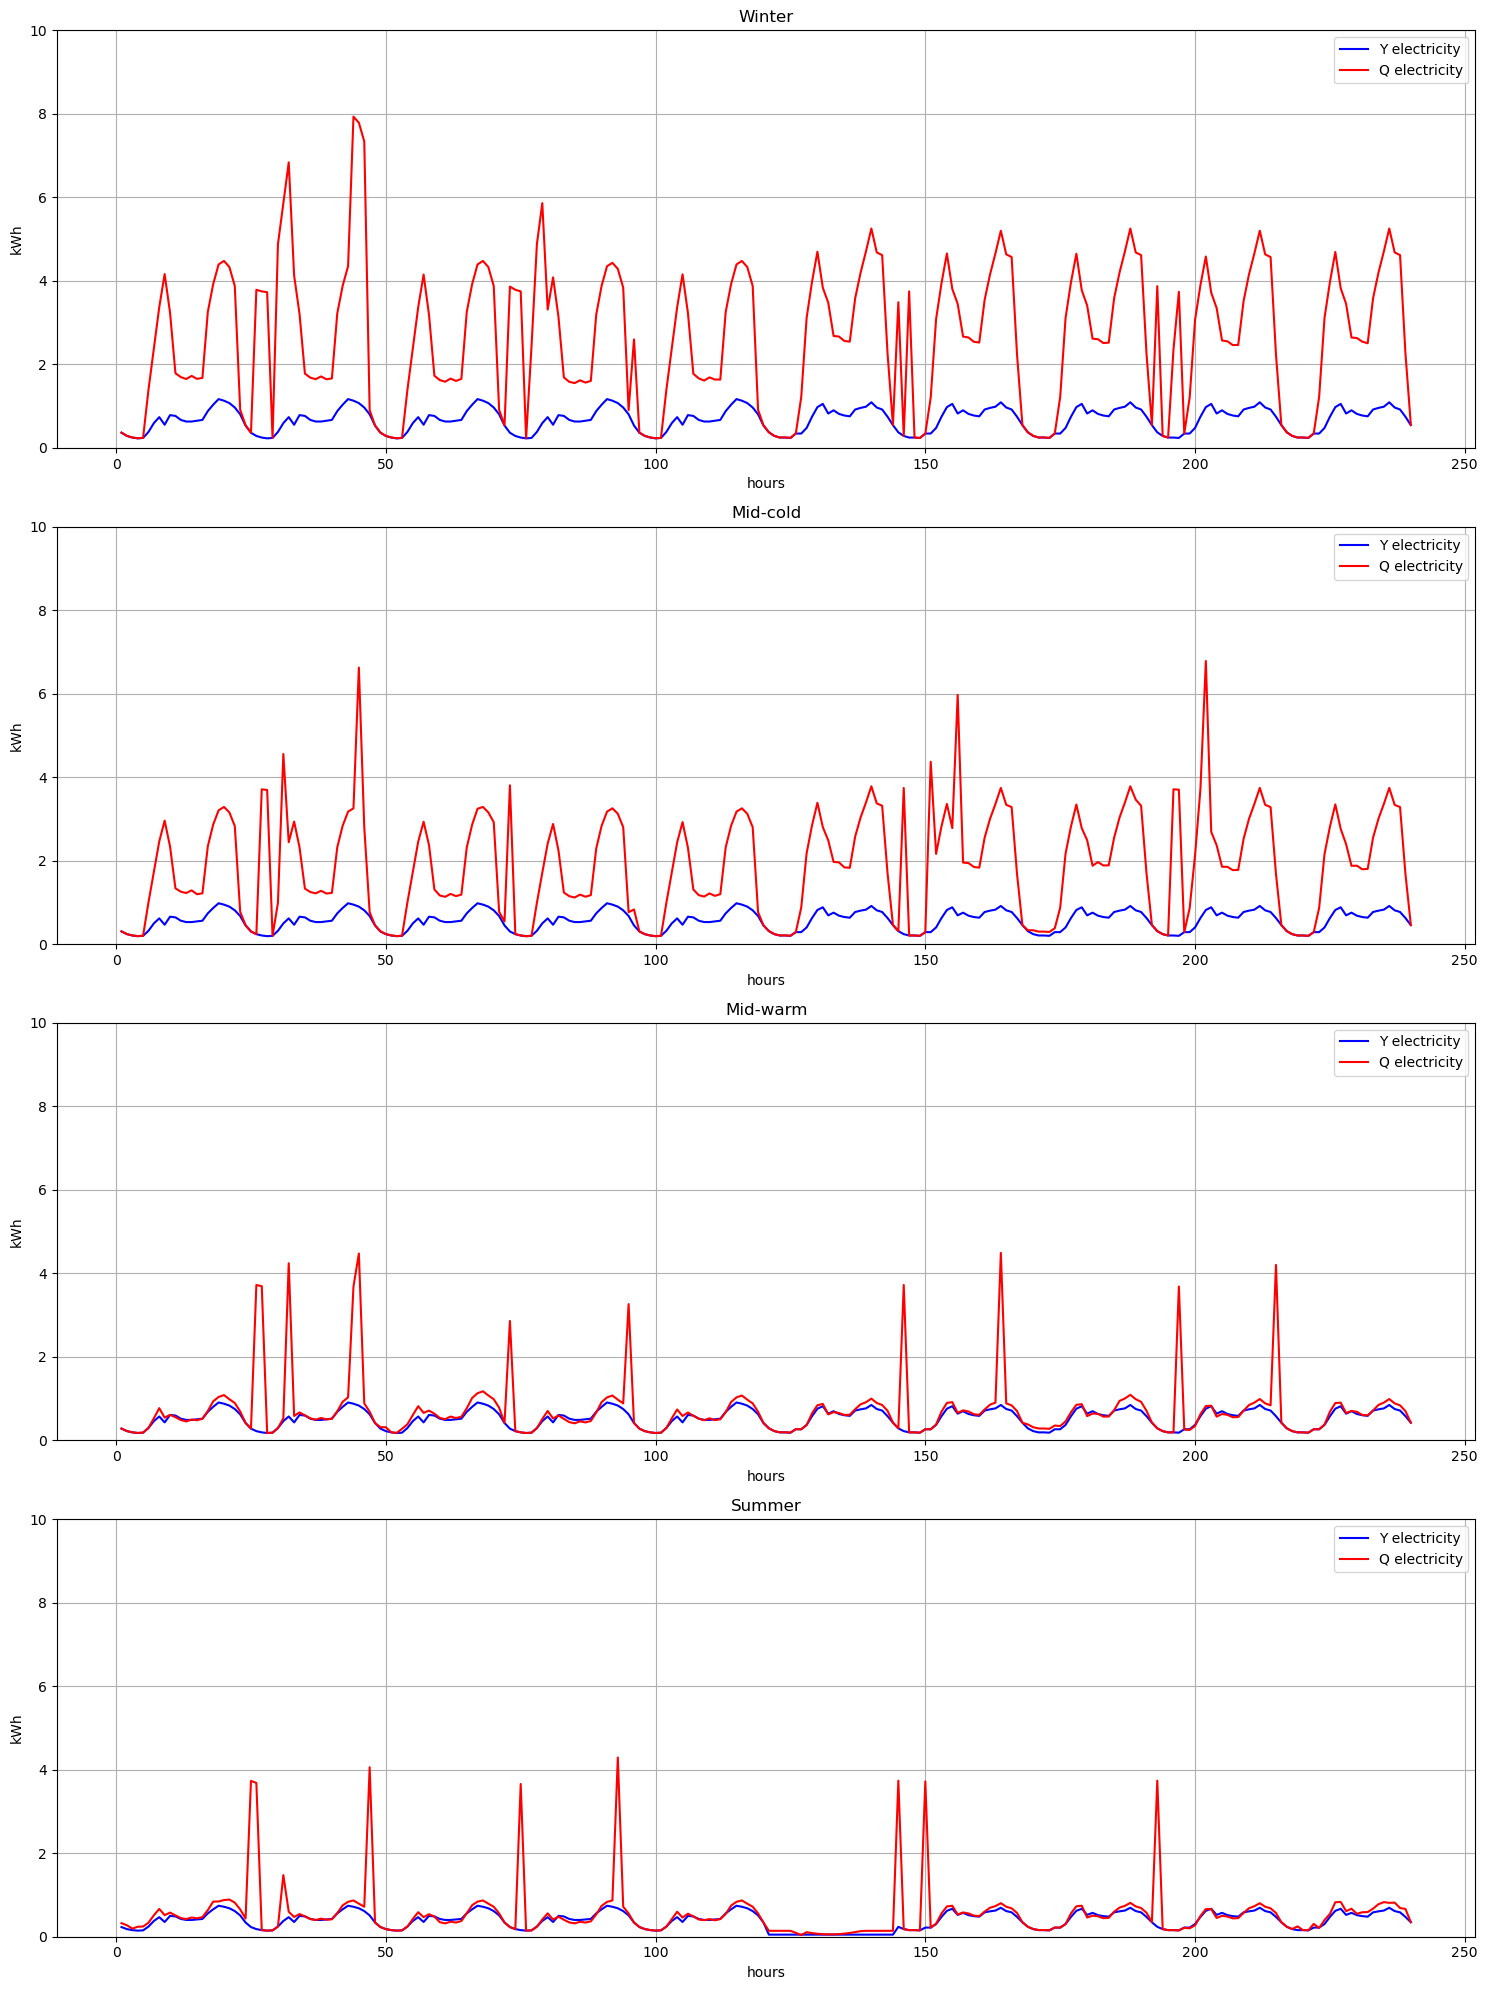

In [115]:
#Electrical demand: direct and indirect
seasons = ['wi', 'mc', 'mw', 'su']
season_names = {'wi': 'Winter', 'mc': 'Mid-cold', 'mw': 'Mid-warm', 'su': 'Summer'}
# Creazione del grafico
plt.figure(figsize=(15, 20))

for i, season in enumerate(seasons, 1):
    Y_season = Y_filtered[Y_filtered['season'] == season]
    Q_season = Q_filtered[Q_filtered['season'] == season]
    X_BEV_season=X_BEV[X_BEV['season']==season]
    
    plt.subplot(4, 1, i)
    plt.plot(Y_season['time'], Y_season['values'], label='Y electricity', color='blue')
    plt.plot(Q_season['time'], Q_season['values'], label='Q electricity', color='red')
    #plt.plot(X_BEV_season['time'], X_BEV_season['values'], label='BEV charging home', color='green')
    plt.xlabel('hours')
    plt.ylabel('kWh')
    plt.ylim(0,10)
    plt.title(f'{season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

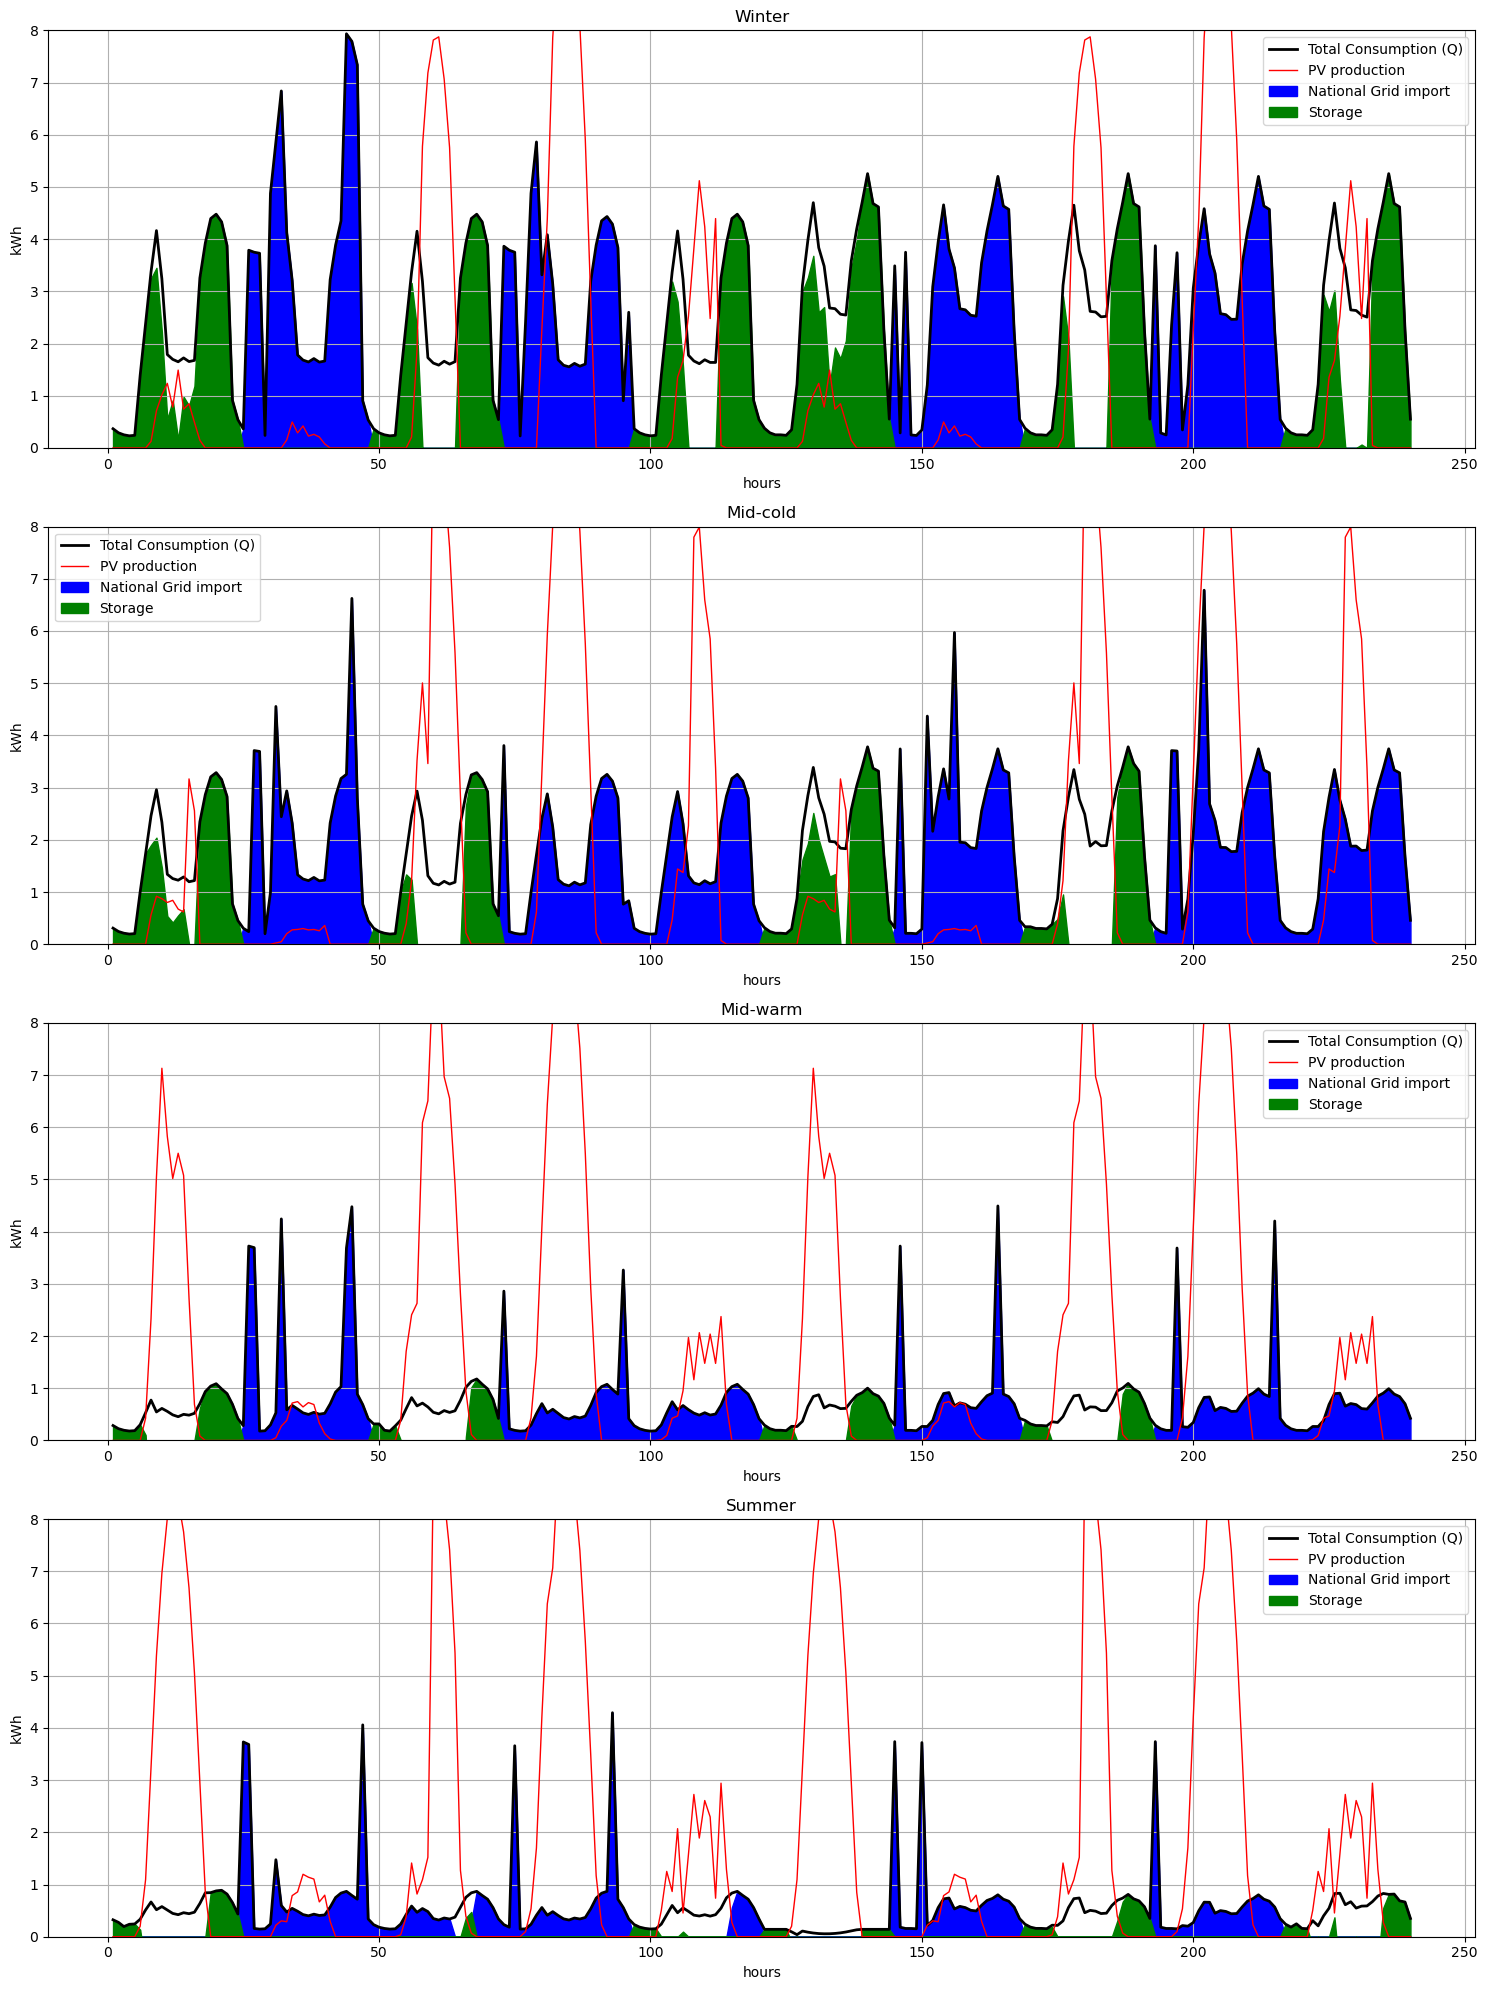

In [116]:
#Electrical demand coverage
Qq= Q[Q['n_names'] == 'EE']
Qq=Qq.iloc[:-1]
PV= X[X['a_names'] == 'PV']
PV=PV.iloc[:-1]
NG= X[X['a_names'] == 'National Grid import']
NG=NG.iloc[:-1]
export= X[X['a_names'] == 'National Grid export']
export=export.iloc[:-1]
Storage= X[X['a_names'] == 'Storing EE']
Storage=Storage.iloc[:-1]
S=Storage.copy()
S['values'] = Storage['values'].clip(lower=0) 
S['values'] = S['values'].to_numpy()-export['values'].to_numpy()

for db in [Qq,PV,NG,S]:
    db.loc[:,'season']=db['th_names'].str[-4:-2]
    db['hour'] = db['th_names'].str[1:3].astype(int)
    db['day'] = db['th_names'].str[-2:].astype(int)
    db['time'] = (db['day'] - 1) * 24 + db['hour']

plt.figure(figsize=(15, 20))

for i, season in enumerate(seasons, 1):
    Q_season = Qq[Qq['season'] == season]
    PV_season = PV[PV['season'] == season]
    NG_season = NG[NG['season'] == season]
    S_season = S[S['season'] == season]
 
    plt.subplot(4, 1, i)
    plt.plot(Q_season['time'], Q_season['values'], color='black', linewidth=2, label='Total Consumption (Q)')
    plt.plot(PV_season['time'], PV_season['values'], color='red', linewidth=1, label='PV production')
    plt.fill_between(NG_season['time'],0, NG_season['values'], color='blue', label='National Grid import')
    plt.fill_between(S_season['time'],0,S_season['values'], color='green', label='Storage')
    plt.xlabel('hours')
    plt.ylabel('kWh')
    plt.ylim(0,8)
    plt.title(f'{season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

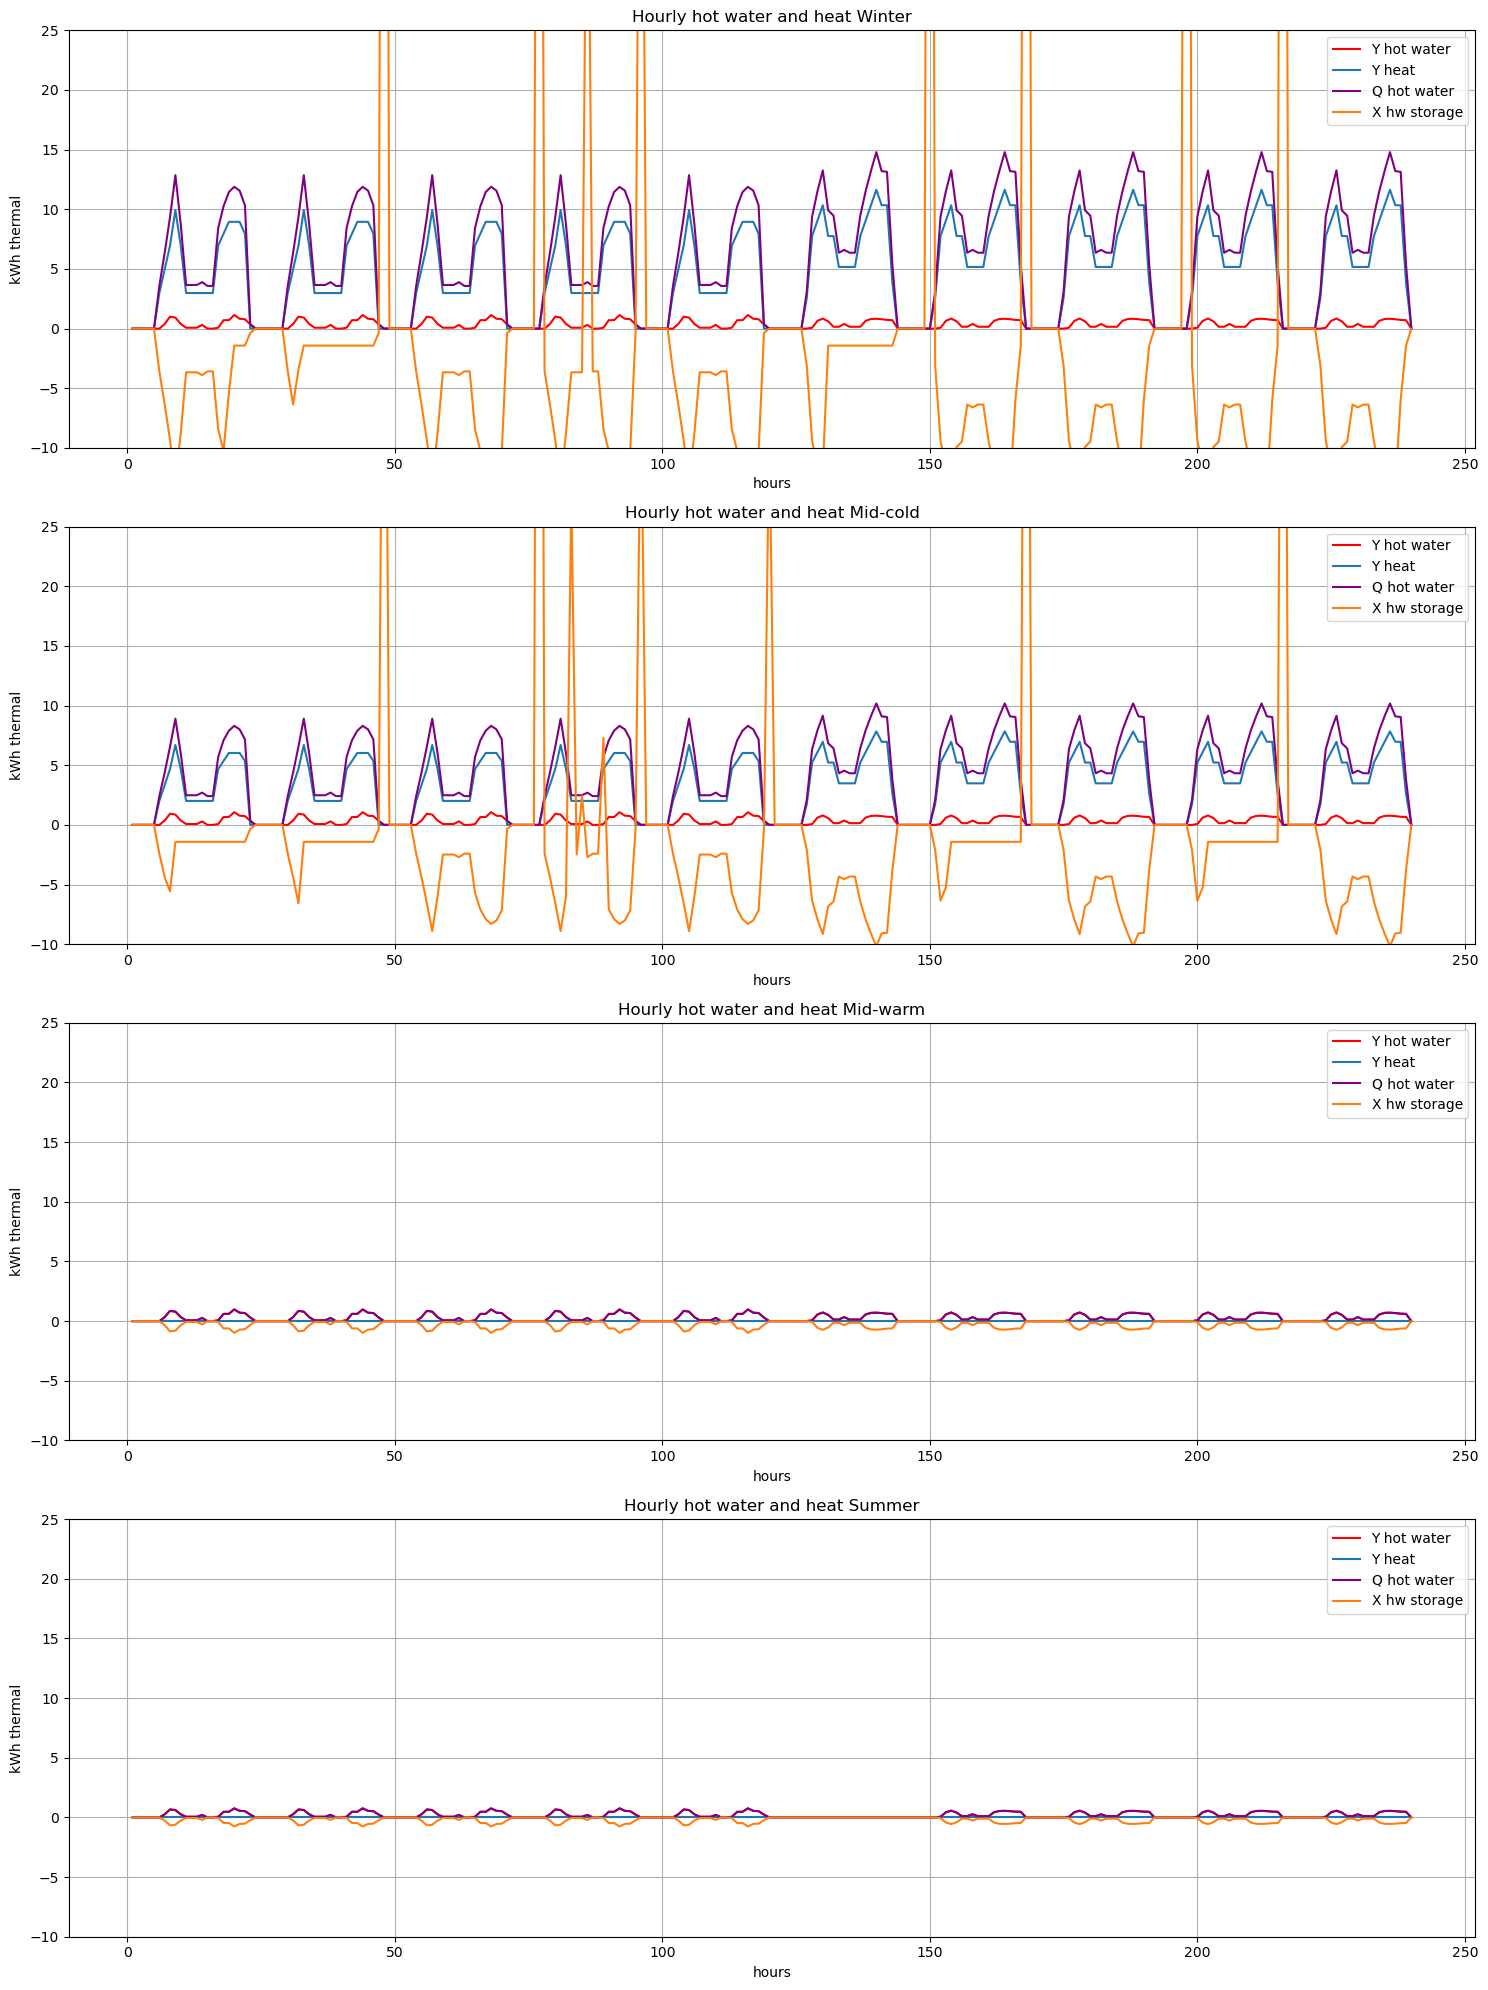

In [123]:
Y_hw = Y[Y['n_names'] == 'Hot water']
Y_hw=Y_hw.iloc[:-1]
Y_heat = Y[Y['n_names'] == 'Heat']
Y_heat=Y_heat.iloc[:-1]
Q_hw = Q[Q['n_names'] == 'Hot water']
Q_hw=Q_hw.iloc[:-1]
X_hw_winter = X[X['a_names'] == 'HP heating winter']
X_hw_winter=X_hw_winter.iloc[:-1]
X_hw_summer = X[X['a_names'] == 'HP heating summer']
X_hw_summer=X_hw_summer.iloc[:-1]
X_hw=X_hw_summer.copy()
X_hw['values'] = X_hw_summer['values']+X_hw_winter['values']

X_hw_stor = X[X['a_names'] == 'Storing HW']
X_hw_stor=X_hw_stor.iloc[:-1]

for df in [Y_hw, Q_hw, X_hw, X_hw_stor,Y_heat]:
    df['season'] = df['th_names'].str[-4:-2]
    df['hour'] = df['th_names'].str[1:3].fillna(0).astype(int)
    df['day'] = df['th_names'].str[-2:].fillna(0).astype(int)
    df['time'] = (df['day'] - 1) * 24 + df['hour']

# Creazione del grafico
plt.figure(figsize=(15, 20))

for i, season in enumerate(seasons, 1):
    X_season = X_hw[X_hw['season'] == season]
    Y_season= Y_hw[Y_hw['season'] == season]
    Yh_season= Y_heat[Y_heat['season'] == season]
    Q_season = Q_hw[Q_hw['season'] == season]
    X_stor_season = X_hw_stor[X_hw_stor['season'] == season]
    
    plt.subplot(4, 1, i)
    plt.plot(Y_season['time'], Y_season['values'], label='Y hot water', color='red')
    plt.plot(Yh_season['time'], Yh_season['values'], label='Y heat')
    plt.plot(Q_season['time'], Q_season['values'], label='Q hot water', color='purple')
    plt.plot(X_stor_season['time'], X_stor_season['values'], label='X hw storage')
    #plt.plot(X_season['time'], X_season['values'], label='X heat pump hw')
    plt.xlabel('hours')
    plt.ylabel('kWh thermal')
    plt.ylim(-10,25)
    plt.title(f'Hourly hot water and heat {season_names[season]}')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

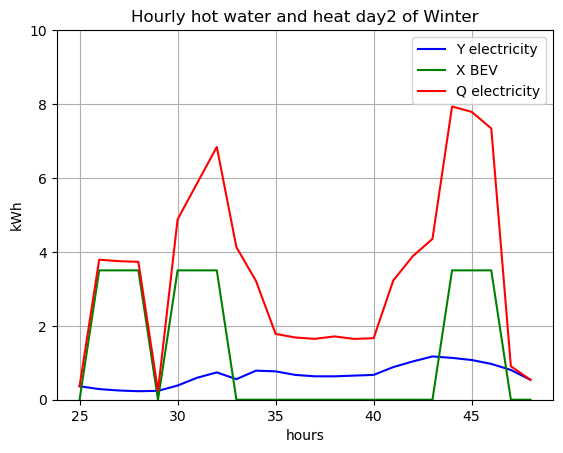

In [117]:
Y_day1 = Y_filtered[(Y_filtered['day'] == 2) & (Y_filtered['season'] == 'wi')]
Q_day1 = Q_filtered[(Q_filtered['day'] == 2) & (Q_filtered['season'] == 'wi')]
X_day1 = X_BEV[(X_BEV['day'] == 2) & (X_BEV['season'] == 'wi')]

plt.plot(Y_day1['time'], Y_day1['values'], label='Y electricity', color='blue')
plt.plot(X_day1['time'], X_day1['values'], label='X BEV', color='green')
plt.plot(Q_day1['time'], Q_day1['values'], label='Q electricity', color='red')
plt.xlabel('hours')
plt.ylabel('kWh')
plt.ylim(0,10)
plt.title(f'Hourly hot water and heat day2 of Winter')
plt.legend()
plt.grid(True)

plt.show()